In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'

## TO do list in experiment.py 
## Notes:
## Freeze weights is on to test storage into memory with fixed linear activity (ac.make_agent arg freeze = True)
# this requires loading the saved weights (agent_params['load_model'] = True)
# in ec.rec_mem temperature is set to 0.1 on softmax -- need to deal with this 
#
## Need the MPLD3 stuff 

## Nov 30: There is the issue of using EC / mf confidence. When rwd is in training location for testing, EC
## should agree with the MF and default to MF. What is happening is that if MF loses confidence, then it 
## fails catastrophically. Need to look into this? 

In [2]:
reload(ac)
grid_params = {
    'y_height':     10, 
    'x_width':      10,
    'walls':        False,
    'rho':          0.0,
    'maze_type':    'none',
    'barheight':    4,
    'port_shift':   'none',
    'step_penaliz': -0.01
    
}

#make environment
maze = eu.gridworld(grid_params)

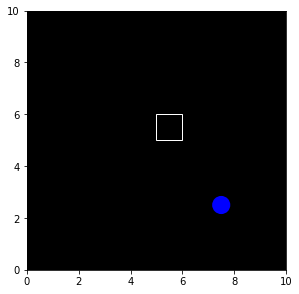

In [10]:
agent_params = {
        'load_model':   True,
        'load_dir':     '../data/outputs/gridworld/openfield{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        
        'state_type':   'conv',
        'lin_dims':     500,
        'action_dims':  len(maze.actionlist),
        'temperature':  1,
    
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        
        'use_EC':       True,
        'cachelim':     300, # memory limit should be ~75% of #actions x #states
        'EC':           {},
        'mem_temp':     0.3
        
    }
run_dict = ac.reset_agt(maze, agent_params)

if agent_params['use_EC']:
    #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
    agent_params['EC'] = ec.ep_mem(run_dict['agent'],agent_params['cachelim'])

gp.plot_env(run_dict['environment'])

In [11]:
'''
CURRENTLY FREEZE WEIGHTS == TRUE
don't forget to turn it off before running trials without preloaded weights
'''

"\nCURRENTLY FREEZE WEIGHTS == TRUE\ndon't forget to turn it off before running trials without preloaded weights\n"

In [12]:
reload(expt)
run_dict = ac.reset_agt(run_dict['environment'], agent_params)
expt.run(run_dict,full=False, rec_mem=True, use_EC=True) ## by default runs truncated trials with MF only

1.0 confidence in model free
rewarded at trial 0
[13:24:40]  Trial 1 TotRew = 0.98 (0.008s)


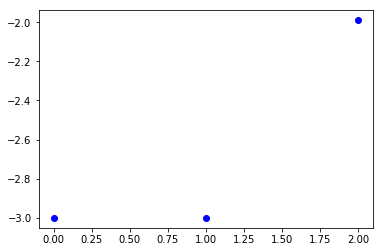

In [6]:
plt.plot(run_dict['total_reward'], 'bo')

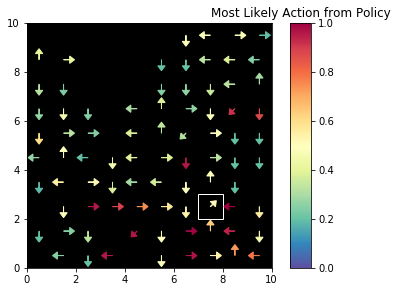

In [7]:
reload(ac)
abcd, efgh = ac.mem_snapshot(maze, 
                       agent_params['EC'], 
                       trial_timestamp = 3, 
                       decay           = ec.calc_env(halfmax = 100), 
                       mem_temp        = 0.1,
                            get_vals=True)#agent_params['mem_temp'])
gp.plot_polmap(maze, abcd)

In [8]:
val_tens = [np.zeros((10,10)) for i in range(6)]
print(len(val_tens))
for index, x in np.ndenumerate(efgh):
    for i in range(6):
        val_tens[i][index]= x[i]

6


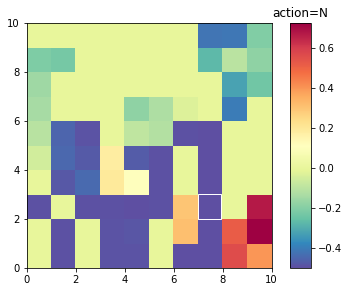

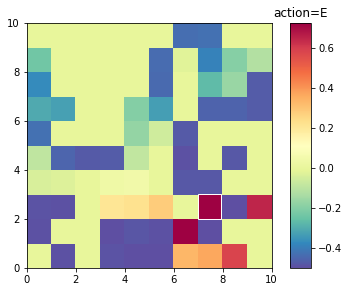

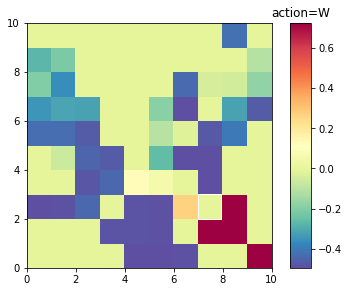

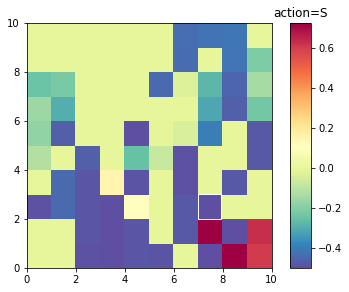

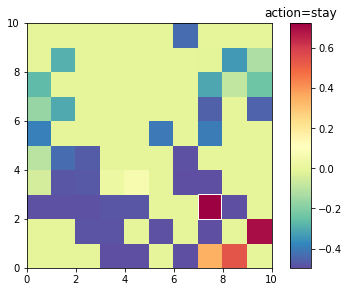

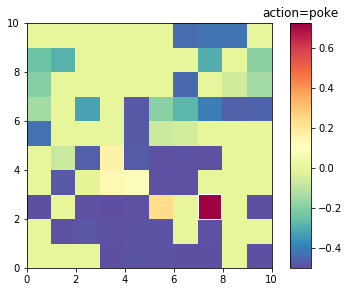

In [9]:
acts = run_dict['environment'].actionlist
reload(gp)
for i in range(6):
    gp.plot_valmap(run_dict['environment'],val_tens[i], p_range = [val_tens[i].min(), val_tens[0].max()], title='action='+acts[i])

In [ ]:
#set_aside = abcd
### this is for plotting the biggest change in the policy after a single reward is received
'''
hootenany = np.zeros_like(abcd)
for index, x in np.ndenumerate(abcd):
    change = np.asarray(list(abcd[index]) - np.asarray(list(set_aside[index])))
    hootenany[index] = tuple(change)

gp.plot_polmap(maze, hootenany)
'''

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range = [0,1.001])

In [ ]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
trial_length = run_dict['trial_length']

In [ ]:
max_ysteps = int(grid_params['y_height']/2)
max_xsteps = int(grid_params['x_width']/2)

reward_threshold = 1+ grid_params['step_penaliz']*(max_xsteps + max_ysteps)
print(reward_threshold)

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(gp.running_mean(tot_reward,30))
ax[0].plot(tot_reward, 'b', alpha = 0.2)
ax[0].axhline(reward_threshold)
#plt.plot(trial_length)
ax[1].plot(policy_loss)
plt.show()
plt.close()

rwd_mean = gp.running_mean(tot_reward,30)
plt.figure(1)
plt.plot(rwd_mean)
plt.plot(tot_reward, 'b', alpha = 0.2)
plt.axhline(reward_threshold)
plt.savefig('rdtest.svg', format='svg')

get_sd =np.where(rwd_mean > reward_threshold)[0][0] 
clipped_pol_loss = policy_loss[get_sd:-1]
print(np.std(clipped_pol_loss))

#pick = [tot_reward, policy_loss, value_loss, trial_length]
#pickle.dump(pick, open("pickles/initial_training.p", "wb"))

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

In [ ]:
reload(gp)


In [ ]:
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=100)
gp.plot_polmap(run_dict['environment'],ttt)

In [ ]:
key_ = 0 
for k, v in agent_params['EC'].cache_list.items():
    if v[2] == (10,10):
        key_ = k
        print(agent_params['EC'].cache_list[key_][0])

plt.figure()
plt.bar(np.arange(6), agent_params['EC'].recall_mem(key_, 26))
plt.ylim([0,1])

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [ ]:
def test_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    mfc      = kwargs.get('conf_score', 1)
    return mfc*np.round(1 / np.cosh(p / envelope), 8)

In [ ]:

a = np.linspace(1,200, 100)#np.sort(np.random.randint(1,100,10))
b = 10*np.arange(10)+5
for i in b:
    a_p = test_pvals(a, envelope=i)
    plt.plot(a, a_p, '-', label=f'{i}')
plt.legend(loc=0)
#ax[1].plot(a_p)


In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
import seaborn as sns


In [ ]:
def make_pvals(p, envelope):
    return np.round(1 / np.cosh(p / envelope), 8)
## try to plot relationship of envelope and half max x value 
bunchadots = np.linspace(0, 1000, 10000)
envs = np.arange(50, step = 2)+1

cp = sns.color_palette(n_colors=len(envs))

tracking = []
for ind, i in enumerate(envs):
    sech = make_pvals(bunchadots, envelope=i)
    plt.plot(bunchadots,sech, color = cp[ind])
    xhalfmax = bunchadots[np.where(sech<0.5)[0][0]]
    plt.plot(xhalfmax,0.5, color = cp[ind], marker = 'o')
    tracking.append((i, xhalfmax))
plt.xlim([0,100])

In [ ]:
bunchadots = np.linspace(0, 10, 1000)
sech = make_pvals(bunchadots, envelope = 0.78967)
plt.plot(bunchadots, sech)
plt.xlim([0,5])
plt.axhline(0.5, color='r')
plt.axvline(1.04, color = 'r')

plt.axvline(3.12, color = 'g')
plt.axhline(0.04, color = 'g')

In [ ]:
a = np.zeros(5)
b = 0.5
for i in range(len(a)):
    a[i] = b*(b**i)
print(a)

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])